This notebook is an introduction to using CausalML for uplift modeling. The code focuses on data simulation, use of meta-learners to estimate Individual Treatment Effect and Conditional Average Treatment Effect. 

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)

Creating a function to generate a synthetic dataset similar to ACLU's use case:

In [2]:
def generate_synthetic_data(num_records):
    data = {
        'Individual_ID': range(1, num_records + 1),
        'Ind_Location': np.random.randint(1, 50, size=num_records),
        'Ind_Age': np.random.randint(18, 65, size=num_records),
        'Ind_Sex': np.random.randint(0, 2, size=num_records),
        'Email_Promotion': np.random.randint(2, size=num_records),
        'Text_Promotion': np.random.randint(2, size=num_records),
        'Ind_Status': np.random.randint(2, size=num_records),
        'Acq_Status': np.random.choice([0, 1, 99], size=num_records),
        'Spend_Value_Base': np.where(np.random.randint(2, size=num_records), np.random.uniform(50, 500, size=num_records), 0),
        'Spend_Value_New': np.where(np.random.randint(2, size=num_records), np.random.uniform(50, 500, size=num_records), 0),
    }
    df = pd.DataFrame(data)
    return df

In [3]:
synthetic_data_manual = generate_synthetic_data(10000)

In [4]:
synthetic_data_manual.head()

,Individual_ID,Ind_Location,Ind_Age,Ind_Sex,Email_Promotion,Text_Promotion,Ind_Status,Acq_Status,Spend_Value_Base,Spend_Value_New
0,1,39,18,1,0,0,0,0,0.0,0.000000
1,2,29,20,0,0,1,0,1,0.0,403.802989
2,3,15,35,1,1,1,0,1,0.0,181.992859
3,4,43,58,1,1,0,0,1,0.0,200.508050
4,5,8,31,0,0,1,1,0,0.0,0.000000


Running some scripts from the causalML example workbook, and adapting them for our synthetic dataset:

In [37]:
from causalml.inference.meta import LRSRegressor
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline


The following code blocks have been taken directly from the causal ml documentation. Implementing each learner based on the instructions in the documents, and then replicating it for manually created synthetic data.

In [7]:
#Synthetic data for Single treatment case (As per causal ml documentation) 
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In the example above:
y is the outcome/dependent variable.
X is the matrix of independent variables or features.
treatment is a binary variable flagging whether an observation was in the treatment or the control group.
tau is the true treatment effect (variable of interest).
b is the set of coefficients for the independent variables.
e is the propensity term representing the probability of treatment 

In [8]:
#Splitting manually generated data to target_var, features, treatment_indicator

y_manual, X_manual, treatment_manual = synthetic_data_manual.loc[:,'Acq_Status'], (synthetic_data_manual.loc[
    :,['Ind_Age','Ind_Location', 'Ind_Sex', 'Ind_Status', 'Spend_Value_Base']
    ]), synthetic_data_manual.loc[:,'Email_Promotion']

S-Learner

In [9]:
# Ready-to-use S-Learner using LinearRegression for causalml's synthetic dataset
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.63862137]), array([0.59012101]), array([0.68712173]))
ATE estimate: 0.639
ATE lower bound: 0.590
ATE upper bound: 0.687
(array([0.63862137]), array([0.59012101]), array([0.68712173]))
ATE estimate: 0.639
ATE lower bound: 0.590
ATE upper bound: 0.687


In the example above, using linear regression as the base learner, and using a S-Learner, we compute the Average Treatment Effect (ATE) to be 0.639. The ATE lower bound and the ATE upper bound values show the confidence interval of this estimate.

The default behavior of the estimate_ate function is to train the model from scratch every time it is called. With the pretrain flag set to True, the function call does not trigger another training from scratch. It uses the pretrained model to compute the ATE on the same or a different dataset.

In [10]:
#Using an S-estimator with a linear regression base model for manually created synthetic dataset
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X_manual, treatment=treatment_manual, y=y_manual)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X_manual, treatment=treatment_manual,
                                y=y_manual, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.65149446]), array([-1.17010321]), array([2.47309212]))
ATE estimate: 0.651
ATE lower bound: -1.170
ATE upper bound: 2.473
(array([0.65149446]), array([-1.17010321]), array([2.47309212]))
ATE estimate: 0.651
ATE lower bound: -1.170
ATE upper bound: 2.473


In the above example, ATE is not significant as data is randomly generated.

T-Learner

In [13]:
# Ready-to-use T-Learner using XGB on causalML's synthetic dataset
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.48439294]), array([0.46033917]), array([0.50844671]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.48439294]), array([0.46033917]), array([0.50844671]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.62680438]), array([0.58539933]), array([0.66820943]))


In the example above, we implement the T-Learner model with XGBoost as the base learner.

In [14]:
#T-Learner for Manual Synthetic Data
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X_manual, treatment=treatment_manual, y=y_manual)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X_manual, treatment=treatment_manual, y=y_manual)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X_manual, treatment=treatment_manual, y=y_manual)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.82565077]), array([-0.54830531]), array([2.19960686]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.82565077]), array([-0.54830531]), array([2.19960686]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.65102516]), array([-1.16787733]), array([2.46992765]))


X-Learner

In [12]:
# X Learner with propensity score input for causalML's synthetic dataset
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.43362888]), array([0.41335295]), array([0.45390481]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.62680438]), array([0.58539933]), array([0.66820943]))


The propensity score matrix e has 10,000 values corresponding to the 10,000 rows in the dataset. These propensity scores are usually calculated using statistical models with the treatment assignment as the dependent variable, and the observed characteristics as the independent variables. Generating the propensity matrix for our synthetic dataset:

In [39]:
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(
    X_manual, y_manual, test_size = 0.2, random_state = 42
)
propensity_model = LogisticRegression()
propensity_model.fit(X_train_manual, y_train_manual)
prediction = propensity_model.predict(X_test_manual)
accuracy = accuracy_score(y_test_manual, prediction)
accuracy



0.318

The underlying data generation process needs to be changed for this model to perform well. Since the data is randomly generated, the prediction accuracy is worse than that of a random prediction.

In [43]:
p_manual = np.array(propensity_model.predict_proba(X_manual)[:,1])

In [44]:
p_manual

array([0.33220031, 0.33870794, 0.33205385, ..., 0.3446131 , 0.35838344,
       0.34716823])

In [45]:
# X Learner with propensity score input for manual dataset
# Calling the Base Learner class and feeding in XGB

learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=p_manual)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=p_manual)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.45988647]), array([0.43940762]), array([0.48036532]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.62680438]), array([0.58539933]), array([0.66820943]))


R-Learners

In [46]:
#Implementing R-Learners on synthetic data from causalML
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.45828523]), array([0.45779641]), array([0.45877405]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.43747606]), array([0.4370556]), array([0.43789651]))


In [47]:
#Implementing R-Learners on synthetic data from causalML
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X_manual, treatment=treatment_manual,
 y=y_manual, p=p_manual)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X_manual, treatment=treatment_manual,
 y=y_manual, p=p_manual)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.70654388]), array([0.68604159]), array([0.72704617]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.60237852]), array([0.58417461]), array([0.62058243]))


Calculating Conditional Average Treatment Effect (CATE) and ITE (Individual Treatment Effect)

In [55]:
#Calculating ITE and CATE using CausalML example

# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

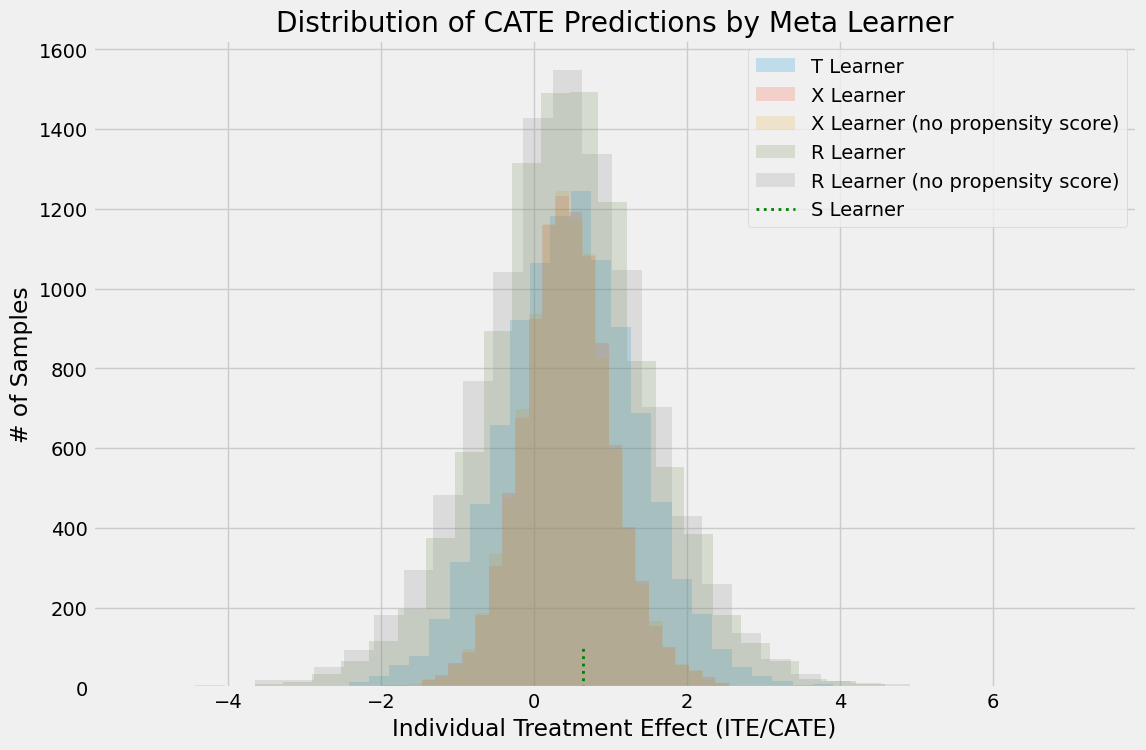

In [56]:
plt.figure(figsize=(12,8))

if len(cate_t) > 0:
    plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
if len(cate_x) > 0:
    plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
if len(cate_x_no_p) > 0:
    plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
if len(cate_r) > 0:
    plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
if len(cate_r_no_p) > 0:
    plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')

if len(cate_s) > 0:
    plt.vlines(cate_s[0], 0, 100, label='S Learner', linestyles='dotted', colors='green', linewidth=2)

plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
plt.legend()

plt.show()

In [50]:
#Calculating ITE and CATE using synthetic dataset

# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X_manual, treatment=treatment_manual, y=y_manual)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X_manual, treatment=treatment_manual, y=y_manual)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X_manual, treatment=treatment_manual, y=y_manual, p=p_manual)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X_manual, treatment=treatment_manual, y=y_manual)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X_manual, treatment=treatment_manual, y=y_manual, p=p_manual)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X_manual, treatment=treatment_manual, y=y_manual)

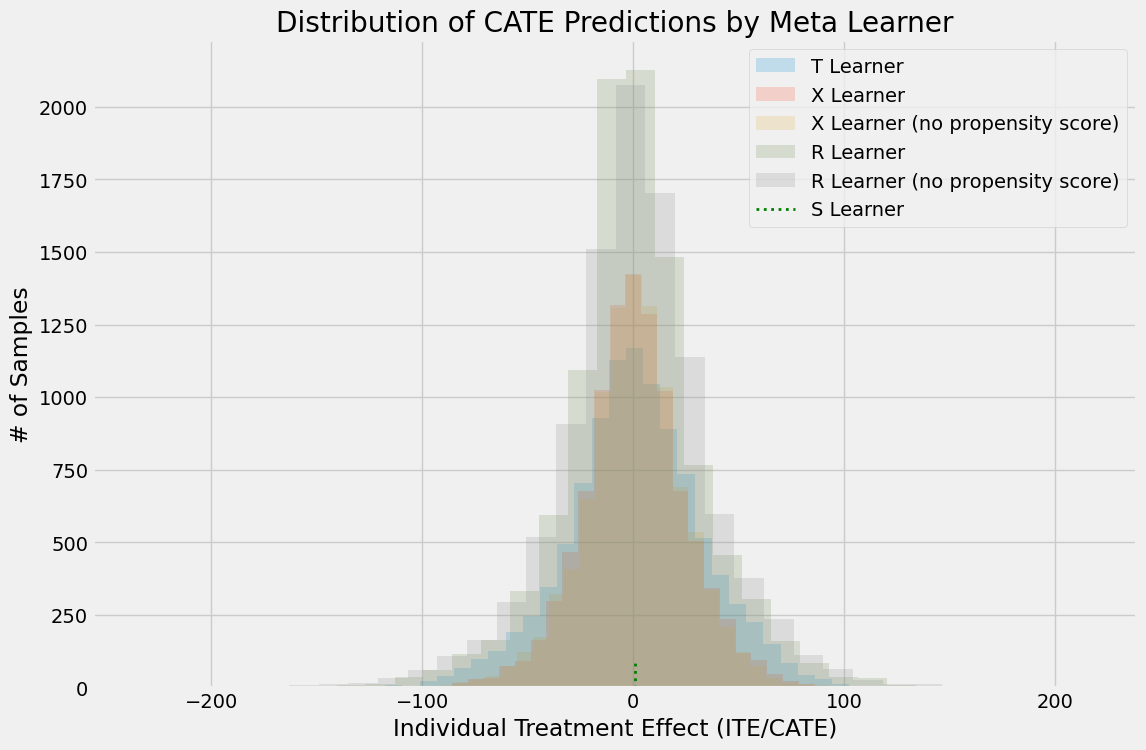

In [54]:


plt.figure(figsize=(12,8))

if len(cate_t) > 0:
    plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
if len(cate_x) > 0:
    plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
if len(cate_x_no_p) > 0:
    plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
if len(cate_r) > 0:
    plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
if len(cate_r_no_p) > 0:
    plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')

if len(cate_s) > 0:
    plt.vlines(cate_s[0], 0, 100, label='S Learner', linestyles='dotted', colors='green', linewidth=2)

plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
plt.legend()

plt.show()


Add evaluation criteria